# Code for post about what predicts importance attributed to personalization among smart speaker users

Emilio Lehoucq

4/12/2023

## Loading libraries and helper functions

In [1]:
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

The following cells 1) clone [this GitHub repository](https://github.com/emiliolehoucq/linkedin_posts) into the [current working directory](https://data-flair.training/blogs/python-directory/#:~:text=To%20find%20out%20which%20directory,use%20the%20getcwd()%20method.&text=Cwd%20is%20for%20current%20working,use%20the%20method%20getcwdb().), 2) load helper functions into the notebook, and 3) remove the directory with the clone of the GitHub repository.

The helper functions can be saved to the notebook.

The cells that load the helper functions into the current notebook don't run the code automatically. After loading the helper functions, you need to run the cells.

To read more about how to clone a GitHub repository and how to remove a directory, see:
- https://stackoverflow.com/questions/52741983/import-a-github-into-jupyter-notebook-directly
- https://stackoverflow.com/questions/43756284/how-to-remove-a-directory-including-all-its-files-in-python

In [2]:
%%bash
git clone https://github.com/emiliolehoucq/linkedin_posts

Cloning into 'linkedin_posts'...


In [3]:
# %load linkedin_posts/code/helper_functions/my_plt_style.py
# I've only used this function with limited data and haven't tested it --Emilio Lehoucq 3/6/2023

def my_plt_style(ax, title, xgrid = False, ygrid = False, grid = False):
    """
    Function to style plot.
    
    Input:
        ax (Axes). Axes of plot.
        title (string). Title of plot. 
        xgrid (Boolean). Optional parameter to add x grid to plot. Default is false.
        ygrid (Boolean). Optional parameter to add y grid to plot. Default is false.
        grid (Boolean). Optional parameter to add both x grid and y grid to plot. Default is false.
    Output:
        None.

    Dependencies:
        The function doesn't automatically load any library, but it's designed to work with matplotlib (as plt).    
    """
    # Bold title:
    plt.title(title, fontweight = 'bold')
    
    # Remove frame around plot:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Add grid:
    if xgrid:
        ax.xaxis.grid(linestyle = '--', color = 'lightgrey')
    elif ygrid:
        ax.yaxis.grid(linestyle = '--', color = 'lightgrey')
    elif grid:
        ax.grid(linestyle = '--', color = 'lightgrey')


In [4]:
# %load linkedin_posts/code/helper_functions/my_weights.py
# I've only used these function with limited data and haven't tested them --Emilio Lehoucq 3/14/23

def weights_univariate(df, col_name, weight_name, percentages = False, rounded = False):
    """
    Function to calculate weighted proportions or percentages.
    
    Input:
        df (dataframe). Pandas dataframe.
        col_name (string). Name of the column to weight.
        weight_name (string). Name of the column with the weights.
        percentages (Boolean). Output percentages rather than proportions (default).
        rounded (Boolean). Round output to two decimals (defaults to False).
    Output:
        Pandas series with weighted proportions or percentages.
    
    Dependencies:
        The function doesn't automatically load any library, but it's designed to work with Pandas.
    
    Code inspired from:
        - https://towardsdatascience.com/how-to-analyze-survey-data-with-python-84eff9cc9568
    """
    # Subset data and group by col_name:
    grouped_data = df[[col_name, weight_name]].groupby(col_name)

    # Calculate number of weighted observations per group and in total:
    counts_per_group = grouped_data.sum()[weight_name]
    total_count = sum(counts_per_group)

    # Calculate proportions or percentages:
    if percentages: result = counts_per_group * 100 / total_count
    else: result = counts_per_group / total_count
    
    # Return result rounded or not:
    if rounded: return round(result, 2)
    else: return result

def weights_bivariate(df, col_1_name, col_2_name, weight_name, out_format = 'counts', rounded = False, verbose = False):
    """
    Function to calculate cross tabulated weighted counts, proportions, or percentages.
    
    Input:
        df (dataframe). Pandas dataframe.
        col_1_name (string). Name of the first categorical column.
        col_2_name (string). Name of the second categorical column.
        weight_name (string). Name of the column with the weights.
        out_format (string). Format of the output: 'counts' (default), 'proportions', or 'percentages'.
        rounded (Boolean). Round output to two decimals (defaults to False).
        verbose (Boolean). Print information to explore association (defaults to false).
    Output:
        Pandas dataframe with weighted counts, proportions, or percentages.

    Dependencies:
        The function doesn't automatically load any library, but it's designed to work with Pandas (as pd) and matplotlib (as plt).

    Code inspired from:
        - https://towardsdatascience.com/how-to-analyze-survey-data-with-python-84eff9cc9568
    """
    # Unweighted cross tabulations:
    xtab_counts = pd.crosstab(df[col_1_name], df[col_2_name])
    xtab_norm = pd.crosstab(df[col_1_name], df[col_2_name], normalize = 'columns')
    # Weighted cross tabulations:
    xtab_counts_w = pd.crosstab(df[col_1_name], df[col_2_name], df[weight_name], aggfunc = sum, dropna = True)
    xtab_norm_w = pd.crosstab(df[col_1_name], df[col_2_name], df[weight_name], aggfunc = sum, dropna = True, normalize = 'columns')

    # Format output:
    if out_format == 'counts': result = xtab_counts_w
    elif out_format == 'proportions': result = xtab_norm_w
    else: xtab_norm, result = xtab_norm * 100, xtab_norm_w * 100
        
    # Round output:
    if rounded: xtab_norm, result = round(xtab_norm, 2), round(result, 2)

    # Display information:
    if verbose:
        print('UNWEIGHTED TABLES (COUNTS AND NORMALIZED):\n')
        print(xtab_counts, '\n')
        print(xtab_norm, '\n')
        print('WEIGHTED TABLE (NORMALIZED):\n')
        print(result)
        print('PLOT (USING WEIGHTS):')
        plot = result.plot.barh(figsize = (6, 3))
        plt.show()
    
    # Return result:
    return result


In [5]:
shutil.rmtree("linkedin_posts")

## Defining helper functions

These helper functions are only to avoid repetition and increase reproducibility *in this script.*

In [6]:
def plot_gridcv_results(data_gridcv_results, args):
    """
    Helper function to plot GridCV results. See usage for structure of args.
    """
    est = args['class'] # estimator
    est_format = str(est).split('.')[-1][:-2]
    # Filtering rows of data_gridcv_results for given estimator:
    df = data_gridcv_results[data_gridcv_results['param_classifier'].apply(lambda x: isinstance(x, args['class']))]
    x_lab = args['x_lab']
    title = est_format + ' gridCV results'
    x_name = args['params']['x'] # hyperparameter to plot on x axis
    y_name = 'mean_test_score'
    
    # for xgb where I tuned two hyperparameters as opposed to one in the other cases:
    if 'group' in args['params'].keys():
        fig, ax = plt.subplots()
        group = args['params']['group'] # second hyperparameter
        # for each unique value of second hyperparameter:
        for i, n_estimator in enumerate(df[group].unique().tolist()):
            df_sub = df[df[group] == n_estimator] # filter rows for that value
            x = df_sub[x_name]
            y = df_sub[y_name]
            plt.plot(x, y, label = f'{group[18:]} = {n_estimator}') # plot line for each value
        plt.legend()
    else:
        ax = df.plot.line(
            x = x_name,
            y = y_name,
            legend = False,
            color = 'gray'
        )
    
    # Add labels to plot, style, and show
    ax.set_xlabel(x_lab)
    plt.ylabel('Mean CV score')
    my_plt_style(ax, title, grid = True)
    plt.show()
    
def pipeline_wrap(pre_ohe, estimator, data_x_train, data_y_train, data_x_test, data_y_test):
    """
    Helper function to fit models.
    """
    # Estimate model on training data:
    pipe_local = Pipeline([
        ('preprocessing', pre_ohe),
        ('classifier', estimator)
    ])
    pipe_local.fit(data_x_train, data_y_train)
    # Get test score:
    print(f'Test score: {round(pipe_local.score(data_x_test, data_y_test), 4)}')
    return pipe_local # I'll use this variable later to visualize models

def model_results(estimator, pipe, pt):
    """
    Helper function to visualize model results.    
    """
    features = pipe.named_steps['preprocessing'].get_feature_names_out()
    df = pd.DataFrame({'metric': np.nan, 'feature': features})
    
    # plot coefficients for ridge and lasso:
    if estimator == 'ridge' or estimator == 'lasso':
        df['metric'] = pipe.named_steps['classifier'].coef_[0]
        # selecting subset of coefficiens to plot:
        pt_pos, pt_neg = pt, pt
        pos_val = np.percentile(df['metric'][df['metric'] > 0], pt_pos)
        neg_val = -np.percentile(df['metric'][df['metric'] < 0].abs(), pt_neg)
        df_subset = df[(df['metric'] > pos_val) | (df['metric'] < neg_val)]
        title = 'Distribution of ' + estimator +' regression coefficients'
        ax = df['metric'][df['metric'] != 0].plot.hist(bins = 200, color = 'gray') # applies to lasso and no effect on ridge
        metric_name = title.split(' ')[-1][:-1].capitalize()
        plt.figtext(0.1, -0.02, f"Note: {df_subset.shape[0]} features to the left or right of the black lines.")
        # Add vertical lines to point to set of coefficients to visualize:
        ax.axvline(x = pos_val, color = 'black')
        ax.axvline(x = neg_val, color = 'black')
    # plot variable importances for rf and xgb
    else:
        df['metric'] = pipe.named_steps['classifier'].feature_importances_
        # selecting subset of coefficients to plot:
        # all feature importances > 0 as opposed to ridge and lasso
        pt_val = np.percentile(df['metric'], pt)
        df_subset = df[(df['metric'] > pt_val)]
        title = 'Distribution of feature importances for ' + estimator
        ax = df['metric'].plot.hist(bins = 200, color = 'gray')
        metric_name = title.split(' ')[-2].capitalize() + ' ' + title.split(' ')[-1][:-1]
        plt.figtext(0.1, -0.02, f"Note: {df_subset.shape[0]} features to the right of the black line.")
        # vertical line pointing out set of coefficients to visualize:
        ax.axvline(x = pt_val, color = 'black')
        
    # Add labels and style
    plt.xlabel(metric_name)
    plt.ylabel('Number of features')
    my_plt_style(ax, title, grid = True)
    plt.show()
    
    # plot either coefficients or feature importances
    ax = df_subset.sort_values('metric').plot.barh(x = 'feature', legend = False, color = 'gray')  
    if estimator == 'ridge' or estimator == 'lasso':
        title = estimator.capitalize() + ' regression coefficients'
        plt.figtext(0.1, -0.02, f"Note: Response coded as '1' for 'important' and '0' for 'not important'.")
    else:
        title = estimator.capitalize() + ' feature importances'
    
    # Add labels and style
    plt.ylabel('Feature')
    plt.xlabel(metric_name)        
    my_plt_style(ax, title, grid = True)
    plt.show()

def create_person(dic, val, features_dic):
    """
    Helper function to create 'personas'/new observations to get predictions.
    """
    for feature in features_dic.keys():
        # replacing value of HOMEASSIST3 by selected value
        if feature == 'HOMEASSIST3': dic[feature] = val
        # all other features leave them blank
        # could change this to create different personas
        else: dic[feature] = 'nan' # np.nan doesn't work
    return dic

## Paths

In [7]:
data_path = '../../data/'
plots_path = '../../plots/published/'

## Reading data

In [8]:
data = pd.read_spss(data_path + 'pew_atp_w_49.sav')

## Cleaning data

In [9]:
INDEX_START_W49 = -4
INDEX_END_F = 2
INDEX_START_FINAL = -6

# Cleaning column names
for column in data.columns.tolist():
    # Drop W_49 from end of column names:
    if column[INDEX_START_W49:] == '_W49':
        data.rename(columns = {column: column[:INDEX_START_W49]}, inplace = True)
    # Drop F_ or _FINAL from column names:
    if column[0:INDEX_END_F] == 'F_':
        if column[INDEX_START_FINAL:] == '_FINAL':
            data.rename(columns = {column: column[INDEX_END_F:INDEX_START_FINAL]}, inplace = True)
        else:
            data.rename(columns = {column: column[INDEX_END_F:]}, inplace = True)

## Exploring data

### Exploring missing data of columns about personalization

In [10]:
columns_of_interest = {
    'HOMEASSIST1': 'Do you have a voice-controlled smart speaker in your home, such as an Amazon Echo or a Google Home?',
    'HOMEASSIST2': 'How concerned are you, if at all, about how much data your smart speaker collects about you?',
    'HOMEASSIST4': 'How important is it that your smart speaker takes your personal interests and preferences into account when responding to your questions or commands?',
    'HOMEASSIST5a': 'Would you like your smart speaker to do a better job of taking your interests and preferences into account in the future?',
    'HOMEASSIST5b': 'Would you like your smart speaker to do a better job of taking your interests and preferences into account in the future, even if that meant it would need to collect more personal information about you?'
}

for name, value in columns_of_interest.items():
    print(name, ": ", value)
    print(f'Percentage missing values: {round(data[name].isnull().mean() * 100, 2)}')
    print(f'Total responses: {data[~data[name].isna()].shape[0]}\n')

HOMEASSIST1 :  Do you have a voice-controlled smart speaker in your home, such as an Amazon Echo or a Google Home?
Percentage missing values: 0.0
Total responses: 4272

HOMEASSIST2 :  How concerned are you, if at all, about how much data your smart speaker collects about you?
Percentage missing values: 75.02
Total responses: 1067

HOMEASSIST4 :  How important is it that your smart speaker takes your personal interests and preferences into account when responding to your questions or commands?
Percentage missing values: 75.02
Total responses: 1067

HOMEASSIST5a :  Would you like your smart speaker to do a better job of taking your interests and preferences into account in the future?
Percentage missing values: 87.34
Total responses: 541

HOMEASSIST5b :  Would you like your smart speaker to do a better job of taking your interests and preferences into account in the future, even if that meant it would need to collect more personal information about you?
Percentage missing values: 87.69
T

In [11]:
# data['HOMEASSIST1'].value_counts(normalize = True)
# 25% of respondents have smart speaker
# HOMEASSIST2 and HOMEASSIST4 asked only if HOMEASSIST1 = 1

# data.loc[(data['FORM'] == 'Form 1') & (data['HOMEASSIST1'] == 'Yes')].shape[0] / data.shape[0]
# 13% of respondents were assigned to Form 1 and have a smart speaker
# HOMEASSIST5a only asked if FORM = 1 AND HOMEASSIST1 = 1

# data.loc[(data['FORM'] == 'Form 2') & (data['HOMEASSIST1'] == 'Yes')].shape[0] / data.shape[0]
# 12% of respondents were assigned to Form 2 and have a smart speaker
# HOMEASSIST5b only asked if FORM = 2 AND HOMEASSIST1 = 1

Most missingness is due to questions being asked to only some respondents based on randomization or conditional on previous answer. This reduces concerns about possible biases.

### Exploring distributions of columns about personalization

In [12]:
for name, value in columns_of_interest.items():
    print("\n--------------------------------------------------\n")
    print(value)
    wp = weights_univariate(data, name, 'WEIGHT')
    print(wp)


--------------------------------------------------

Do you have a voice-controlled smart speaker in your home, such as an Amazon Echo or a Google Home?
HOMEASSIST1
No         0.751976
Refused    0.001580
Yes        0.246443
Name: WEIGHT, dtype: float64

--------------------------------------------------

How concerned are you, if at all, about how much data your smart speaker collects about you?
HOMEASSIST2
Not concerned at all    0.095246
Not too concerned       0.360294
Somewhat concerned      0.402413
Very concerned          0.142047
Name: WEIGHT, dtype: float64

--------------------------------------------------

How important is it that your smart speaker takes your personal interests and preferences into account when responding to your questions or commands?
HOMEASSIST4
Not important at all    0.120044
Not too important       0.314716
Refused                 0.007926
Somewhat important      0.377901
Very important          0.179413
Name: WEIGHT, dtype: float64

-----------------

25% of respondents have a voice-controlled smart speaker in their home. (Who are they? More tech-y? See below.)

Relative to the numbers I saw for CONCERNCO and CONCERNGOV, people who have smart speakers don't seem to be very concernd about how much data their smart speaker collects about them. 36% are not too concerned and 10% are not concerned at all. Only 14% are very concerned and 40% somewhat concerned.

Even then, there is not an overwhelming majority who believes that it is important that their smart speaker takes their personal interests and preferences into account when responding to their questions and commands. Only 18% believes it is very important and 38% somewhat important, while 12% not important at all and 31% not too important.

Even more so, less than half of respondents would like their smart speaker to do a better job at taking their interests and preferences into account in the future (42% yes vs 58% no). This is even less so when doing that would mean smart speakers would need to collect more personal information. In that case, only 33% of people would want more personalization.

This could be because of how they use their smart speaker. If you only, say, ask the smart speaker to play the news or a song that you already had in mind, it doesn't matter that much whether the smart speaker takes your personal interests and preferences into account. That'd be more important if you ask the smart speaker for recommendations.

In [13]:
# Learning a bit more about users of smart speakers:
data_smart = data.loc[data['HOMEASSIST1'] == 'Yes']
data_not_smart = data.loc[data['HOMEASSIST1'] == 'No']

columns_techyness = {
    'SNSUSER': 'Do you use any social media (among Facebook, Instagram, Twitter, or others)?',
    'HOMEIOT': 'Do you have other connected items in your home that you can control from your phone, such as smart lighting or a connected thermostat or alarm system?',
    'FITTRACK': 'Do you regularly wear a smart watch or a wearable fitness tracker?',
    'DNATEST': 'Have you ever used a mail-in DNA testing service from a company such as AncestryDNA or 23andMe?',
    'CONCERNCO': 'How concerned are you, if at all, about how companies are using the data they collect about you?',
    'BENEFITCO': 'How much do you feel you personally benefit from the data that companies collect about you?',
    'POSNEGCO': 'On balance, which would you say most accurately describes how you feel?'    
}

for name, value in columns_techyness.items():
    print("\n--------------------------------------------------\n")
    print(value)
    print('\nRespondents who HAVE a voice-controlled smart speaker in their home:\n')
    wp_smart = weights_univariate(data_smart, name, 'WEIGHT')
    print(wp_smart)
    print("\nRespondents who DON'T HAVE a voice-controlled smart speaker in their home:\n")
    wp_not_smart = weights_univariate(data_not_smart, name, 'WEIGHT')
    print(wp_not_smart)


--------------------------------------------------

Do you use any social media (among Facebook, Instagram, Twitter, or others)?

Respondents who HAVE a voice-controlled smart speaker in their home:

SNSUSER
Does not use social media    0.101743
Social media user            0.898257
Name: WEIGHT, dtype: float64

Respondents who DON'T HAVE a voice-controlled smart speaker in their home:

SNSUSER
Does not use social media    0.205853
Social media user            0.794147
Name: WEIGHT, dtype: float64

--------------------------------------------------

Do you have other connected items in your home that you can control from your phone, such as smart lighting or a connected thermostat or alarm system?

Respondents who HAVE a voice-controlled smart speaker in their home:

HOMEIOT
No         0.562257
Refused    0.010168
Yes        0.427575
Name: WEIGHT, dtype: float64

Respondents who DON'T HAVE a voice-controlled smart speaker in their home:

HOMEIOT
No         0.877028
Refused    0.001622

Relative to people who don't have a voice-controlled smart speaker in their home, people who do are :
- ~10% more likely to be a social media user.
- ~30% more likely to have other connected items in their home that they can control from their phone, such as smart lighting or a connected thermostat or alarm system
- ~22% more likely to regularly wear a smart watch or wearable fitness tracker
- ~12% more likely to have ever used mail-in DNA testing service from a company such as AncestryDNA or 23andMe
- ~14% less likelt to be very concerned about how companies are using the data they collect about them and ~5% more likely to not be too concerned, but also ~10% more likely to be somewhat concerned
- ~10% more likely to believe that they personally benefit some from the data that companies collect about them, ~2% more likely to believe they benefit a great deal, and ~12% less likely to feel that they benefit none
- ~10% more likely to believe that the benefits they get from companies collecting data about them outweigh the potential risks

Considering the techyness of the people who have smart speakers, it seems low that:
- only 18% believe it's very important and 38% somewhat important that their smart speaker takes their personal interests and preferences into account when responding to their questions and commands.
- less than half would like their smart speaker to do a better job at taking their interests and preferences into account in the future (42% yes vs 58% no).
- only 33% would want more personalization "even if that meant [the smart speaker] would need to collect more personal information about [them]?" (although I don't love the phrasing)

Overall, I think this is evidence that American consumers don't place much value in personalization.

### Selecting and cleaning subset of data for modeling

In [14]:
# Creating deep copy of data for modeling
data_modeling = data.copy(deep = True)

# Converting HOMEASSIST4 into binary
# There are less than 200 respondents that answered 'Very important' or 'Not important at all'
# Predicting each of the four categories creates more sparsity and reduces the information about each category
data_modeling['HOMEASSIST4'].replace(
    ['Not important at all', 'Not too important', 'Refused', 'Somewhat important', 'Very important'],
    [0, 0, np.nan, 1, 1],
    inplace = True
)
print(f"\nDistribution of response:\n\n{data_modeling['HOMEASSIST4'].value_counts()}\n")
print(round(data_modeling['HOMEASSIST4'].value_counts(normalize = True), 2))
print(f"\nWith weights:\n {round(weights_univariate(data_modeling, 'HOMEASSIST4', 'WEIGHT'), 2)}")

# Keeping only rows where HOMEASSIST4 is not missing
# There are very few missing data, so no concerned about bias
data_modeling = data_modeling[~data_modeling['HOMEASSIST4'].isna()]
print(f'\ndata_modeling.shape: {data_modeling.shape}')

# Separating features from response:
data_features = data_modeling.drop('HOMEASSIST4', axis = 1)
print(f'data_features.shape: {data_features.shape}')

# Dropping some columns from features
data_features = data_features.drop([
    'QKEY',
    'FORM',
    'EDUCCAT2', # Included another education column
    'RACECMB', # Included another race column
    'PARTYLN', # Included another party column
    'PARTYSUM', # Included another party column
    'INCOME', # Included another income column
    'WEIGHT', # not necessary for my purposes/models
    'HOMEASSIST1', # all yes given my subset
    'HOMEASSIST5a', # too similar
    'HOMEASSIST5b', # too similar
    'TRACKCNT', 
    'TOTALKNOW'
], axis = 1)
print(f'\n{data_features.shape[1]} columns after dropping irrelevant columns')

# Exploring missing values:
perc_thres = 2
count_nan = 0
for column in data_features:
    perc_nan = data_features[column].isnull().mean() * 100
    if perc_nan > perc_thres:
#         print(column, ": ")
#         print(f'Percentage missing values: {round(perc_nan, 2)}')
#         print(f'Total responses: {data_features[~data_features[column].isna()].shape[0]}\n')
        count_nan += 1

# All missingness--except for INCOME_RECODE (3% nan) and IDEO (2% nan)--is due to questions being
# asked to only some respondents based on randomization or conditional on previous answer
# This reduces concerns about possible biases
    
print(f'\n{count_nan} columns have more than {perc_thres}% of missing values')

# Spliting into train and test set
seed = 3123 # I'll reuse this seed below
x_train, x_test, y_train, y_test = train_test_split(
    data_features,
    data_modeling.HOMEASSIST4,
    test_size = 0.2, # could decrease to have more data for training, but unreliable test
    random_state = seed
)
print(f'\nSize of:\nx_train = {x_train.shape}\nx_test = {x_test.shape}\ny_train = {y_train.shape}\ny_test = {y_test.shape}')


Distribution of response:

1.0    584
0.0    478
Name: HOMEASSIST4, dtype: int64

1.0    0.55
0.0    0.45
Name: HOMEASSIST4, dtype: float64

With weights:
 HOMEASSIST4
0.0    0.44
1.0    0.56
Name: WEIGHT, dtype: float64

data_modeling.shape: (1062, 143)
data_features.shape: (1062, 142)

129 columns after dropping irrelevant columns

67 columns have more than 2% of missing values

Size of:
x_train = (849, 129)
x_test = (213, 129)
y_train = (849,)
y_test = (213,)


### Modeling

In [15]:
# Müller & Guido, "Introduction to Machine Learning with Python":

# OneHotEncoder() makes it easier than pd.get_dummies() to treat training and test sets consistently 
# nan on the original column are set to 0 in all dummy columns (row is not deleted)
# I could impute missing values first. I'll keep it this way given that there 
# are no concerns about biases from missing data

# The splitting of the dataset during crossvalidation should be done before any preprocessing.
# Any process that extracts knowledge from the dataset should only ever be learned from the
# training portion of the dataset, and therefore be included inside the crossvalidation loop

# Pipeline() and GridSearchCV() simplify the process of building chains of transformations and 
# models while searching over parameters for all steps at once. Pipeline combines multiple
# processing steps into a single sklearn estimator. Pipeline has fit, predict, and score
# that behave like any model

# I selected this parameters by experimenting and looking at the graphs below
# parameter for logistic:
iterations = 300
# parameters for ridge:
alphas = range(150, 350, 50)
# parameters for lasso:
cs = np.linspace(0.001, 0.25, 5)
# parameters for random forests:
rf_max_features = list(range(1, x_train.shape[1], 10))
if x_train.shape[1] not in rf_max_features: rf_max_features.append(x_train.shape[1])
# parameters for boosted trees:
xgboost_learning_rate = [0.001, 0.005]
xgboost_learning_rate.extend(np.linspace(0.01, 0.07, 7))
xgboost_n_estimators = range(50, 250, 50)

# to avoid repetition:
ohe = OneHotEncoder(handle_unknown = 'ignore')
lr = LogisticRegression(max_iter = iterations)

pipe = Pipeline([
    ('preprocessing', ohe),
    ('classifier', lr)
])

params = [
    {
        'preprocessing': [
            OneHotEncoder(handle_unknown = 'ignore', drop = 'first') # v perfect collinearity
        ],
        'classifier': [lr]
    },
    {
        'preprocessing': [ohe],
        'classifier': [RidgeClassifier()],
        'classifier__alpha': alphas
    },
    { # https://stackoverflow.com/questions/36697297/python-classification-lasso-sklearn-how-to-predict-classes
        'preprocessing': [ohe],
        'classifier': [lr],
        'classifier__penalty': ['l1'],
        'classifier__C': cs,
        'classifier__solver': ['liblinear']
    }, # tuning the hyperparameters that tend to be more impactful:
    {
        'preprocessing': [ohe],
        'classifier': [RandomForestClassifier()],
        'classifier__random_state': [seed],
        'classifier__oob_score': [True], # should make it faster
        'classifier__max_features': rf_max_features,
    },
    {
        'preprocessing': [ohe],
        'classifier': [GradientBoostingClassifier()],
        'classifier__random_state': [seed],
        'classifier__learning_rate': xgboost_learning_rate,
        'classifier__n_estimators': xgboost_n_estimators
    }
]

grid = GridSearchCV(
    pipe,
    param_grid = params,
    cv = 5 # 10 would create too much sparsity. 3 might be too little
)

grid.fit(x_train, y_train)

gridcv_results = pd.DataFrame(grid.cv_results_)

print(f'Estimated {gridcv_results.shape[0]} models')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [2, 20, 25, 28, 59, 96, 117, 120] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [10, 36, 43, 50, 89, 105] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [31, 57, 75, 87, 88, 90, 91, 92, 102] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [33, 85] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/anaconda3/li

Estimated 60 models


###  Evaluating training

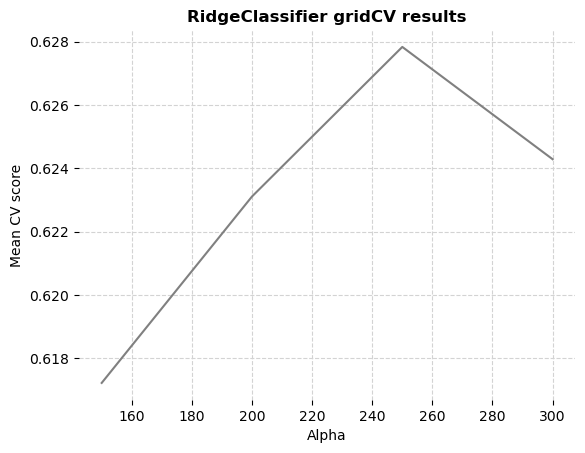

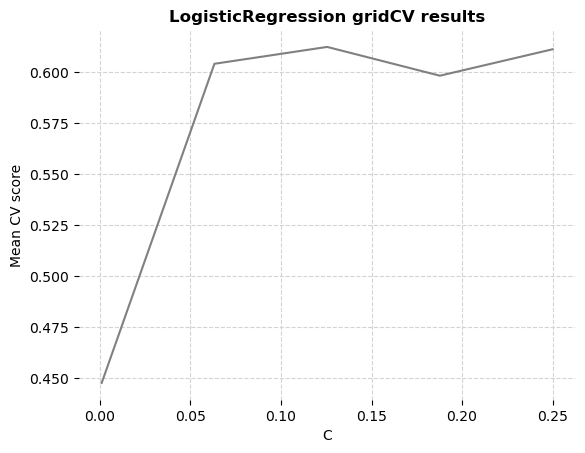

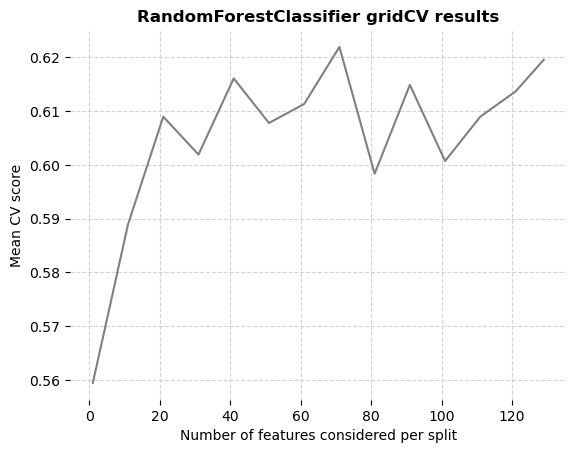

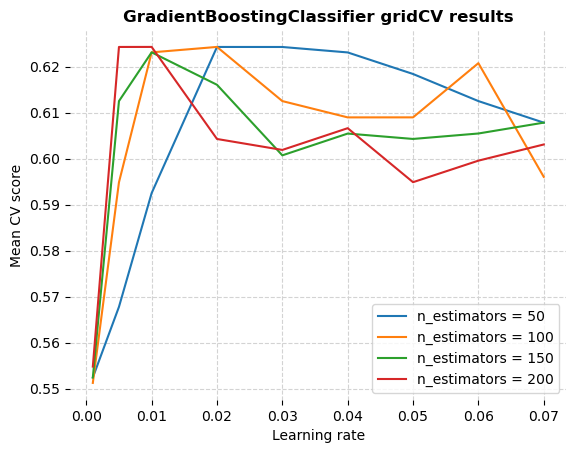

In [16]:
args_ridge = {
    'class': RidgeClassifier,
    'params': {
        'x': 'param_classifier__alpha'
    },
    'x_lab': 'Alpha'
}

args_lasso = {
    'class': LogisticRegression, # lasso
    'params': {
        'x': 'param_classifier__C'
    },
    'x_lab': 'C'
}

args_rf = {
    'class': RandomForestClassifier,
    'params': {
        'x': 'param_classifier__max_features'
    },
    'x_lab': 'Number of features considered per split'
}

args_xgb = {
    'class': GradientBoostingClassifier,
    'params': {
        'x': 'param_classifier__learning_rate',
        'group': 'param_classifier__n_estimators'
    },
    'x_lab': 'Learning rate'
}

for args in [args_ridge, args_lasso, args_rf, args_xgb]:
    plot_gridcv_results(gridcv_results, args)

Seems that range of hyperparameters is broad enough to see max performance.

### Evaluating models

In [17]:
for est in [RidgeClassifier, LogisticRegression, RandomForestClassifier, GradientBoostingClassifier]:
    # Filter gridcv_results for given class of estimator:
    df_subset = gridcv_results[gridcv_results['param_classifier'].apply(lambda x: isinstance(x, est))]
    # Find best estimator for given class:
    df_max = df_subset.loc[df_subset['mean_test_score'].idxmax()]
    # Get max training score
    max_score = round(df_max.loc['mean_test_score'], 4) 
    # Get name of estimator
    algo = str(est).split('.')[-1][:-2]
    print(f"\nClass: {algo}")
    print(f'Train score: {max_score}')
    # For each best estimator, estimate new model on all training data and test on test data:
    if algo == "RidgeClassifier":
        alpha = df_max['param_classifier__alpha'] # alpha for best ridge
        print(f"Alpha: {alpha}")
        pipe_ridge = pipeline_wrap(ohe, RidgeClassifier(alpha = alpha), x_train, y_train, x_test, y_test)
    elif algo == "LogisticRegression":
        c = df_max['param_classifier__C'] # C for best lasso
        print(f"C: {c}")
        pipe_lasso = pipeline_wrap(
            ohe,
            LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear'),
            x_train,
            y_train,
            x_test,
            y_test
        )
    elif algo == "RandomForestClassifier":
        max_features = df_max['param_classifier__max_features'] # max_features for best rf
        print(f"max_features: {max_features}")
        pipe_rf = pipeline_wrap(
            ohe,
            RandomForestClassifier(random_state = seed, oob_score = True, max_features = max_features),
            x_train,
            y_train,
            x_test,
            y_test
        )
    else:
        lr = df_max['param_classifier__learning_rate'] # learning_rate for best xgb
        n_est = df_max['param_classifier__n_estimators'] # n_estimators for best xgb
        print(f"learning_rate: {lr}\nn_estimators: {n_est}")
        pipe_xgb = pipeline_wrap(
            ohe,
            GradientBoostingClassifier(random_state = seed, learning_rate = lr, n_estimators = n_est),
            x_train,
            y_train,
            x_test,
            y_test
        )


Class: RidgeClassifier
Train score: 0.6278
Alpha: 250
Test score: 0.6009

Class: LogisticRegression
Train score: 0.6125
C: 0.1255
Test score: 0.5962

Class: RandomForestClassifier
Train score: 0.6219
max_features: 71
Test score: 0.6103

Class: GradientBoostingClassifier
Train score: 0.6243
learning_rate: 0.01
n_estimators: 200
Test score: 0.6103


All estimators perform rather similarly. Since CV is random process, it's not good practice to overemphasize small differences. Tree-based methods may perform slightly better. This suggests there could be important non-linearities. I'd be curious to see with more data.

Models perform better than naïve classifier (0.55, which is the proportion of the majority class). Models improve over naïve classifier 9-10%. This is not a huge amount, but models do include useful information. Also, 9-10% improvement could be useful for certain use cases.

### Visualizing models

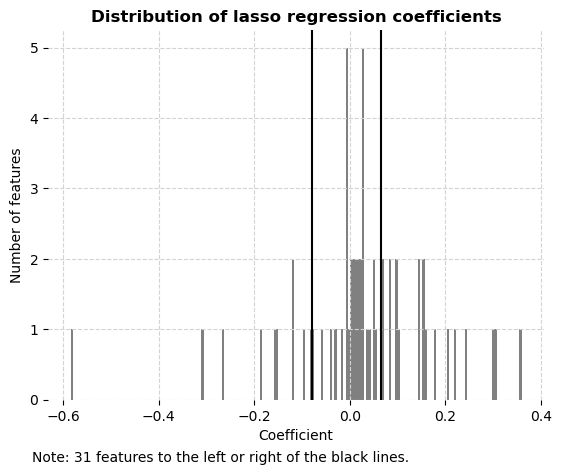

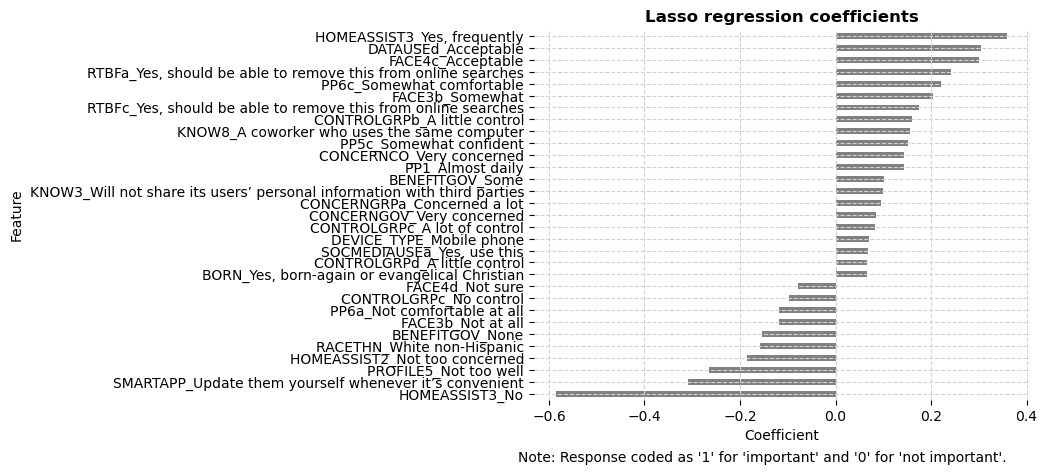

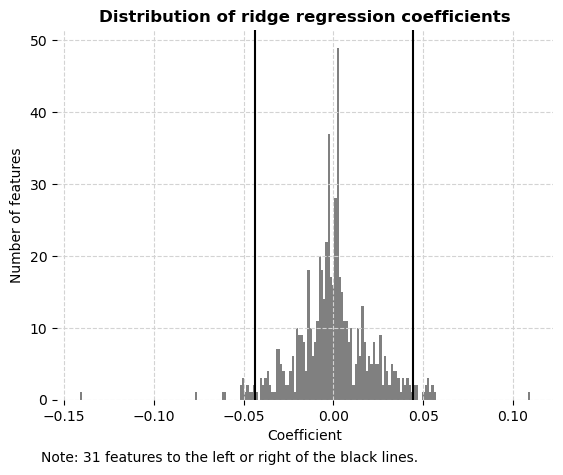

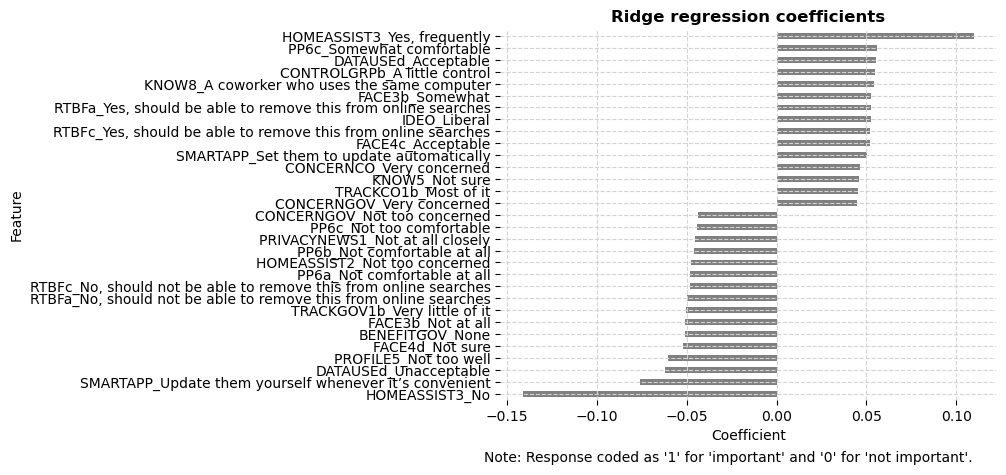

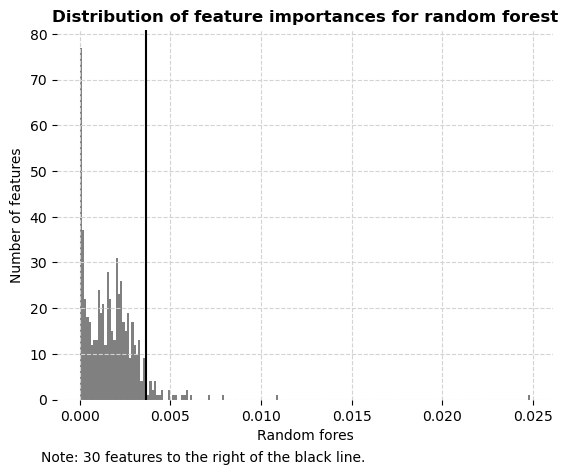

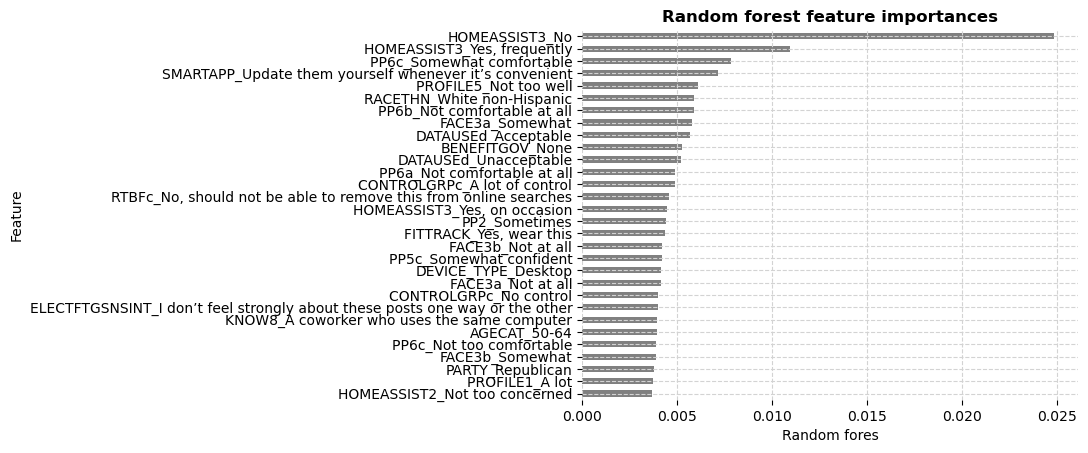

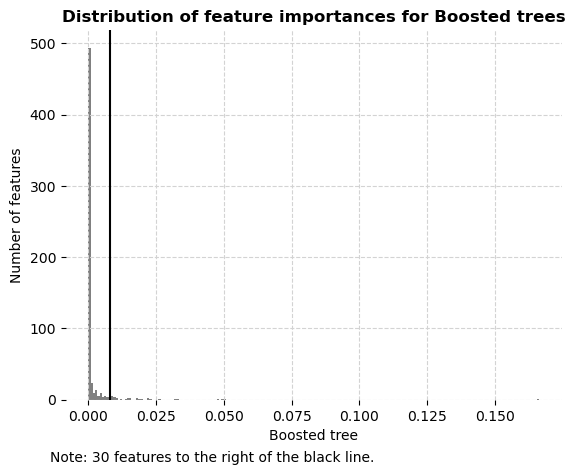

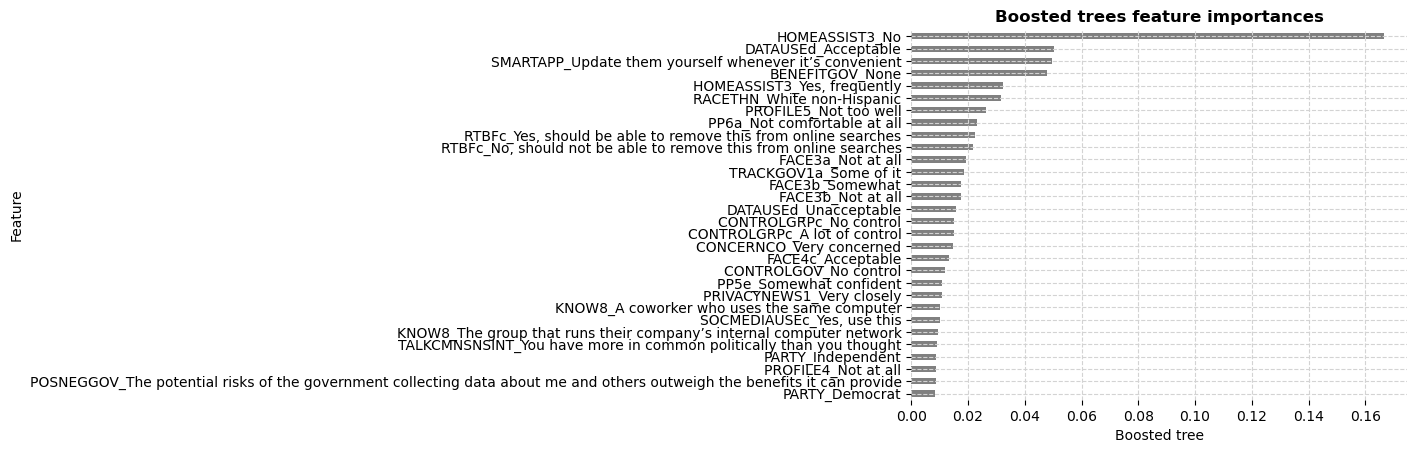

In [18]:
models = [
    ('lasso', pipe_lasso, 50),
    ('ridge', pipe_ridge, 95),
    ('random forest', pipe_rf, 95),
    ('Boosted trees', pipe_xgb, 95)]

for model in models:
    model_results(model[0], model[1], model[2])

HOMEASSIST3 = Do you ever say “please” when speaking to your smart speaker?<br>
PP6c = How comfortable are you, if at all, with companies using your personal data in the following ways? // To help them develop new products.<br>
SMARTAPP = How do you typically update the apps on your smartphone?

------

=>

- People who say 'please' to their smart speakers seem to be place more value on personalization. This is the most important predictor.
- People who are somewhat comfortable with companies using their personal data to develop new products seem to place more value on personalization.
- People who update the apps on their smartphone whenever it's convenient (the other options are update them automatically, as soon as they are notified a new version is available, and never) seem to place less value on personalization.

### Obtaining predictions for most important feature

In [19]:
# Creating dict with each feature and possible categories for that feature:
features = {}
for col in x_train.columns.tolist(): features[col] = x_train[col].cat.categories.tolist()

# empty dicts to create new 'personas' to get predictions
new_frequently, new_occasion, new_no = {}, {}, {}

# for each estimator:
for pipe in [pipe_rf, pipe_xgb, pipe_lasso, pipe_ridge]:
    # create 'personas':
    fake_freq = pd.DataFrame([create_person(new_frequently, 'Yes, frequently', features)])
    fake_occ = pd.DataFrame([create_person(new_occasion, 'Yes, on occasion', features)])
    fake_no = pd.DataFrame([create_person(new_no, 'No', features)])
    print(str(pipe.named_steps['classifier']).split("(")[0] + ':')
    # RidgeClassifier doesn't have predict_proba method. See explanation below
    if pipe == pipe_ridge:
        d_freq = pipe_ridge.decision_function(fake_freq)[0]
        d_occ = pipe_ridge.decision_function(fake_occ)[0]
        d_no = pipe_ridge.decision_function(fake_no)[0]
        freq = round(np.exp(d_freq) / (1 + np.exp(d_freq)), 2)
        occ = round(np.exp(d_occ) / (1 + np.exp(d_occ)), 2)
        no = round(np.exp(d_no) / (1 + np.exp(d_no)), 2)
    # obtaining predicted probabilities
    else:
        freq = round(pipe.predict_proba(fake_freq)[0][1], 2)
        occ = round(pipe.predict_proba(fake_occ)[0][1], 2)
        no = round(pipe.predict_proba(fake_no)[0][1], 2)
    print(f"Frequently: {freq}")
    print(f"Occasionally: {occ}")
    print(f"No: {no}\n")

RandomForestClassifier:
Frequently: 0.78
Occasionally: 0.74
No: 0.46

GradientBoostingClassifier:
Frequently: 0.75
Occasionally: 0.68
No: 0.46

LogisticRegression:
Frequently: 0.59
Occasionally: 0.5
No: 0.36

RidgeClassifier:
Frequently: 0.6
Occasionally: 0.58
No: 0.54



Consistent with interpretation above. Difference seems rather important.

Note: I'm not completely sure on the predicted probabilities for RidgeClassifier. 

This [website](https://itecnote.com/tecnote/python-scikit-learn-ridge-classifier-extracting-class-probabilities/) suggests calculating the probabilities using the formula:<br>

`d = clf.decision_function(x)[0]` <br>
`probs = numpy.exp(d) / (1 + numpy.exp(d))`

I looked at the source code (on 3/4/2023), and for [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), if `multi_class = 'auto'` (which is the default) and `solver = 'liblinear'` (which I selected), then `predict_proba(X)` is defined as:
`super()._predict_proba_lr(X)` (line 1372 [here](https://github.com/scikit-learn/scikit-learn/blob/8c9c1f27b/sklearn/linear_model/_logistic.py)). The source code of LogisticRegression imports `LinearClassifierMixin` from `._base`.

In `._base` ([here](https://github.com/scikit-learn/scikit-learn/blob/8c9c1f27b7e21201cfffb118934999025fd50cca/sklearn/linear_model/_base.py)), the class `LinearClassifierMixin` includes the method `_predict_proba_lr(X)` (lines 427 - 441), whose definition says that "Positive class probabilities are computed as `1. / (1. + np.exp(-self.decision_function(X)))`".

Both are equivalent:

In [20]:
d_freq_test = pipe_ridge.decision_function(pd.DataFrame([create_person(new_frequently, 'Yes, frequently', features)]))
d_no_test = pipe_ridge.decision_function(pd.DataFrame([create_person(new_frequently, 'No', features)]))

# Stack Overflow answer:
print(np.exp(d_freq_test) / (1 + np.exp(d_freq_test)))
print(np.exp(d_no_test) / (1 + np.exp(d_no_test)))

# My answer:
print(1. / (1. + np.exp(-d_freq_test)))
print(1. / (1. + np.exp(-d_no_test)))

[0.60085176]
[0.53941185]
[0.60085176]
[0.53941185]


### Comparing with crosstab

UNWEIGHTED TABLES (COUNTS AND NORMALIZED):

HOMEASSIST3            No  Refused  Yes, frequently  Yes, on occasion
HOMEASSIST4                                                          
Not important at all  100        0               12                25
Not too important     174        0               47               120
Refused                 2        1                0                 2
Somewhat important    156        0               94               163
Very important         52        0               57                62 

HOMEASSIST3                 No  Refused  Yes, frequently  Yes, on occasion
HOMEASSIST4                                                               
Not important at all  0.206612      0.0         0.057143          0.067204
Not too important     0.359504      0.0         0.223810          0.322581
Refused               0.004132      1.0         0.000000          0.005376
Somewhat important    0.322314      0.0         0.447619          0.438172
Very important

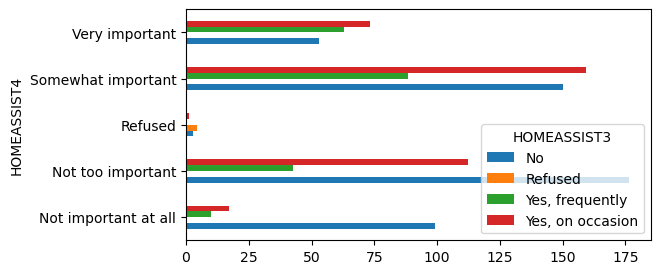

In [21]:
xtab_plot = weights_bivariate(data, 'HOMEASSIST4', 'HOMEASSIST3', 'WEIGHT', verbose = True)

Consistent with interpretation above.

Somewhat less clear for HOMEASSIST4 = Somewhat important.

## Plot for post

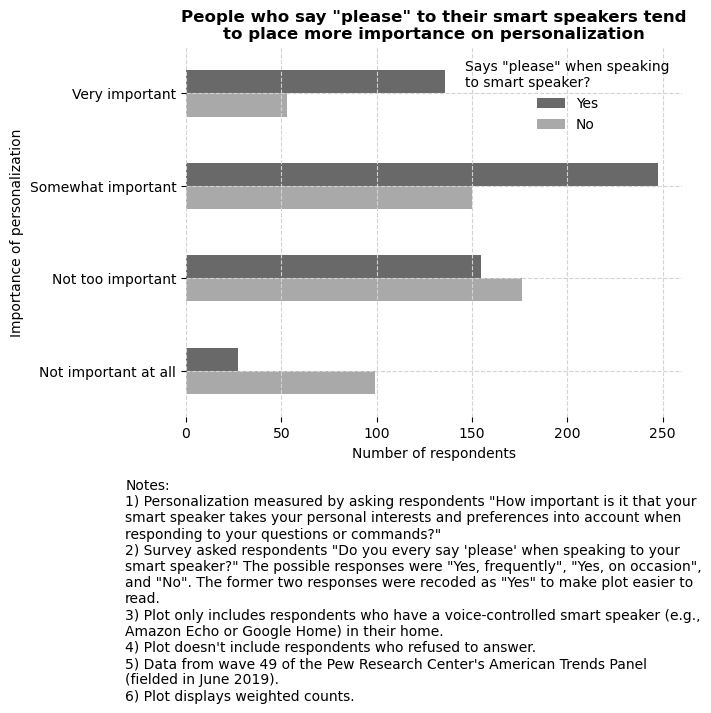

In [22]:
df_plot = xtab_plot.loc[xtab_plot.index != 'Refused', xtab_plot.columns != 'Refused']
df_plot['Yes'] = df_plot['Yes, frequently'] + df_plot['Yes, on occasion']
df_plot = df_plot[['No', 'Yes']]

color = {'No': 'darkgray', 'Yes': 'dimgray'}
ax = df_plot.plot.barh(color = color)

title = 'People who say "please" to their smart speakers tend\nto place more importance on personalization'
ax.set_xlabel('Number of respondents')
ax.set_ylabel("Importance of personalization")

# https://stackoverflow.com/questions/34576059/reverse-the-order-of-a-legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title = 'Says "please" when speaking\nto smart speaker?', frameon = False)

plt.figtext(0.03, -0.48, 'Notes:\n1) Personalization measured by asking respondents "How important is it that your\nsmart speaker takes your personal interests and preferences into account when\nresponding to your questions or commands?"\n2) Survey asked respondents "Do you every say \'please\' when speaking to your\nsmart speaker?" The possible responses were "Yes, frequently", "Yes, on occasion",\nand "No". The former two responses were recoded as "Yes" to make plot easier to\nread.\n3) Plot only includes respondents who have a voice-controlled smart speaker (e.g.,\nAmazon Echo or Google Home) in their home.\n4) Plot doesn\'t include respondents who refused to answer.\n5) Data from wave 49 of the Pew Research Center\'s American Trends Panel\n(fielded in June 2019).\n6) Plot displays weighted counts.')
my_plt_style(ax, title, grid = True)

plt.savefig(plots_path + "4_12_2023.png", bbox_inches = 'tight', dpi = 120)